In [54]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d

%matplotlib inline

In [25]:
def curvature_splines(x, y=None, error=0.1):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
         or
         y=None and
         x is a numpy.array(dtype=complex) shape (n_points, )
         In the second case the curve is represented as a np.array
         of complex numbers.
    error : float
        The admisible error when interpolating the splines
    Returns
    -------
    curvature: numpy.array shape (n_points, )
    Note: This is 2-3x slower (1.8 ms for 2000 points) than `curvature_gradient`
    but more accurate, especially at the borders.
    """

    # handle list of complex case
    if y is None:
        x, y = x.real, x.imag

    t = np.arange(x.shape[0])
    std = error * np.ones_like(x)

    fx = UnivariateSpline(t, x, k=4, w=1 / np.sqrt(std))
    fy = UnivariateSpline(t, y, k=4, w=1 / np.sqrt(std))

    xˈ = fx.derivative(1)(t)
    xˈˈ = fx.derivative(2)(t)
    yˈ = fy.derivative(1)(t)
    yˈˈ = fy.derivative(2)(t)
    curvature = (xˈ* yˈˈ - yˈ* xˈˈ) / np.power(xˈ** 2 + yˈ** 2, 3 / 2)

    return curvature

Diagnostics from Mazzini and Barth (2013) *"A comparison of mechanisms generating vertical transport in the
Brazilian coastal upwelling regions"*, JGR Oceans 118

$$w_{-h} = -\frac{H}{2f}\left(\mathbf{V}_1\cdot\nabla\zeta_1 + \beta v_1\right) + \frac{h_1}{2f}\left[\frac{\partial}{\partial x}\left(\frac{\tau_o^y}{\rho_1h_1}\right) - \frac{\partial}{\partial y}\left(\frac{\tau_o^x}{\rho_1h_1}\right)  \right]$$

$$\zeta = -\frac{\partial V}{\partial n} + \frac{V}{R}$$

$$W_{total} = \underbrace{\overbrace{\frac{\tau_o^y}{\rho f}}^{W_{coastal}} + \overbrace{\int_0^L\frac{1}{2\rho f}\left(\frac{\partial\tau_o^y}{\partial x} - \frac{\partial\tau_o^x}{\partial y}\right)dx}^{W_{curl}}}_{wind} - \underbrace{\overbrace{\frac{Hv_o^2}{2fS}\tan \alpha}^{W_{tshear}} - \overbrace{\frac{Hv_o\left|v_o\right|S}{6f}\frac{\partial R^{-1}}{\partial y}}^{W_{tradius}}}_{topography}$$

In [5]:
# Load Bathymetry
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)

In [143]:
# Calculate coastline curvature
p = c.collections[0].get_paths()[2]
v = p.vertices
x = np.arange(len(v))
gridX = interp1d(x[::5], v[::5, 0], kind='linear')(x[:-8])
gridY = interp1d(x[::5], v[::5, 1], kind='linear')(x[:-8])
curve = curvature_splines(gridX, y=gridY)/500*1e3

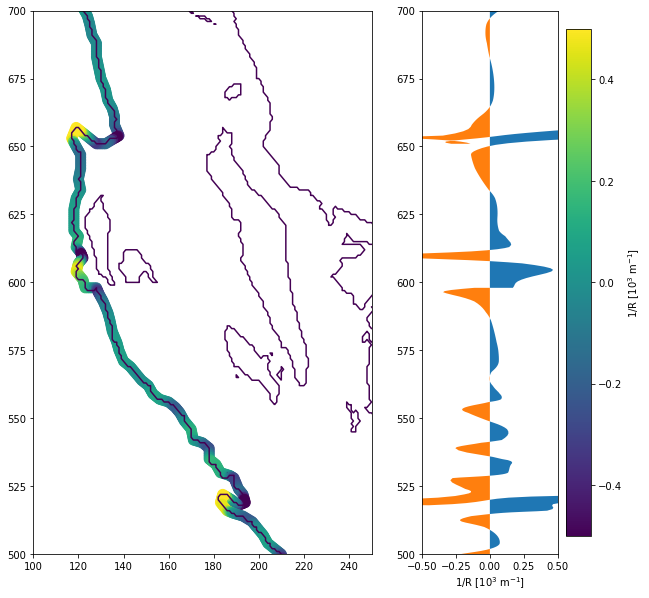

In [153]:
# Plot curvature
fig, axs = plt.subplots(1, 2, figsize=(10, 10), gridspec_kw={'width_ratios': [2, 1]})
c = axs[0].contour(bathy.Bathymetry, levels=[-0.01, 0.01])
cs = axs[0].scatter(gridX, gridY, s=100, c=curve, vmin=-.5, vmax=.5)
axs[0].set_xlim([100, 250])
axs[0].set_ylim([500, 700])
index = (gridX>100) & (curve>0)
axs[1].fill_betweenx(gridY, curve, where=index, interpolate=True)
index = (gridX>100) & (curve<0)
axs[1].fill_betweenx(gridY, curve, where=index, interpolate=True)
axs[1].set_xlim([-.5, .5])
axs[1].set_ylim([500, 700])
axs[1].set_xlabel('1/R [10$^3$ m$^{-1}$]')

fig.colorbar(cs, label='1/R [10$^3$ m$^{-1}$]')